## Author: Ksnenofontov Gregory

## Task

В качестве тестового задания мы предоставляем вам датасет online_shoppers_intention.csv, который содержит информацию о посетителях интернет-магазина и их поведении на сайте. Необходимо проанализировать данный датасет, определив какие действия могут привести к конверсии и создать классификатор на основе ваших гипотез.

В качестве ответа необходимо предоставить Jupyter Notebook с вашим анализом и модель машинного обучения, которая сможет предсказывать, приносят ли действия пользователя Revenue или нет.

## Imports

In [208]:
# Data
import pandas as pd

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


## Data Analysis

### Summary analysis

In [135]:
dataframe = pd.read_csv('online_shoppers_intention.csv')
dataframe.sample(5)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
319,1,14.0,0,0.00,46,1380.166667,0.000000,0.010370,0.000,0.0,Mar,4,1,1,1,Returning_Visitor,False,False
10331,1,11.0,3,47.75,25,1925.979167,0.023077,0.056026,0.000,0.0,Dec,2,2,7,2,Returning_Visitor,False,False
9140,3,96.0,0,0.00,12,175.175000,0.020000,0.031111,0.000,0.0,Dec,3,2,8,2,New_Visitor,False,False
11680,0,0.0,0,0.00,21,607.589286,0.028571,0.051323,0.000,0.0,Dec,3,2,1,2,Returning_Visitor,True,False
2791,1,44.5,0,0.00,18,519.500000,0.000000,0.035000,20.394,0.0,May,2,2,7,13,Returning_Visitor,False,False


Для большего понимания признаков был найден [источник](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset) данного датасета

Далее расписаны наиболее специфичные их них

"**Administrative**", "**Administrative Duration**", "**Informational**", "**Informational Duration**", "**Product Related**" и "**Product Related Duration**" представляют собой количество различных типов страниц, посещенных посетителем за один сеанс, и общее время, проведенное в каждой из этих категорий страниц.

Параметр "**Bounce Rate**" для веб-страницы относится к проценту посетителей, которые заходят на сайт с этой страницы, а затем покидают ("bounce"), не инициируя никаких других запросов к серверу аналитики во время этого сеанса. 

Параметр "**Exit Rate**" для конкретной веб-страницы рассчитывается как для всех просмотров страницы на странице процент, которые были последними в сеансе. 

Параметр "**Page Value**" представляет собой среднюю ценность веб-страницы, которую пользователь посетил до завершения транзакции электронной торговли. 

Параметр "**Special Day**" указывает на близость времени посещения сайта к определенному особому дню (например, Дню матери, Дню святого Валентина), когда сеансы с большей вероятностью завершатся транзакцией. Значение этого атрибута определяется с учетом динамики электронной торговли, такой как продолжительность между датой заказа и датой доставки. Например, для дня Валентины это значение принимает ненулевое значение между 2 и 12 февраля, ноль до и после этой даты, если только она не близка к другому особому дню, и максимальное значение 1 приходится на 8 февраля.

Рассмотрим есть ли пропущеные значения и каких типов бывают признаки в данном датасете

In [136]:
dataframe.info()

# Select categorical features
cat_cols = list(dataframe.select_dtypes(exclude='number').columns)

# Select numerical features
num_cols = list(dataframe.select_dtypes(include='number').columns)

print(f'All categorical features: {", ".join(cat_cols)}')
print(f'All numerical features: {", ".join(num_cols)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Из полученных результатов видно, что нет пропущеных значений, а также имеется 8 категориальных признаков (Month, VisitorType, Weekend, Revenue, OperatingSystems, Browser, Region, TrafficType), из которых 4 последних уже закодированы LabelEncoder'ом.

In [137]:
dataframe.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Из сводной таблици видно, что большинство численных признаков распределены в близи нуля, например Administrative,  Administrative_Duration, Informational, Informational_Duration, PageValues

Для более детального анализа рассмотрим каждый из признаков отдельно.

### Descriptive analysis

<Axes: xlabel='Administrative'>

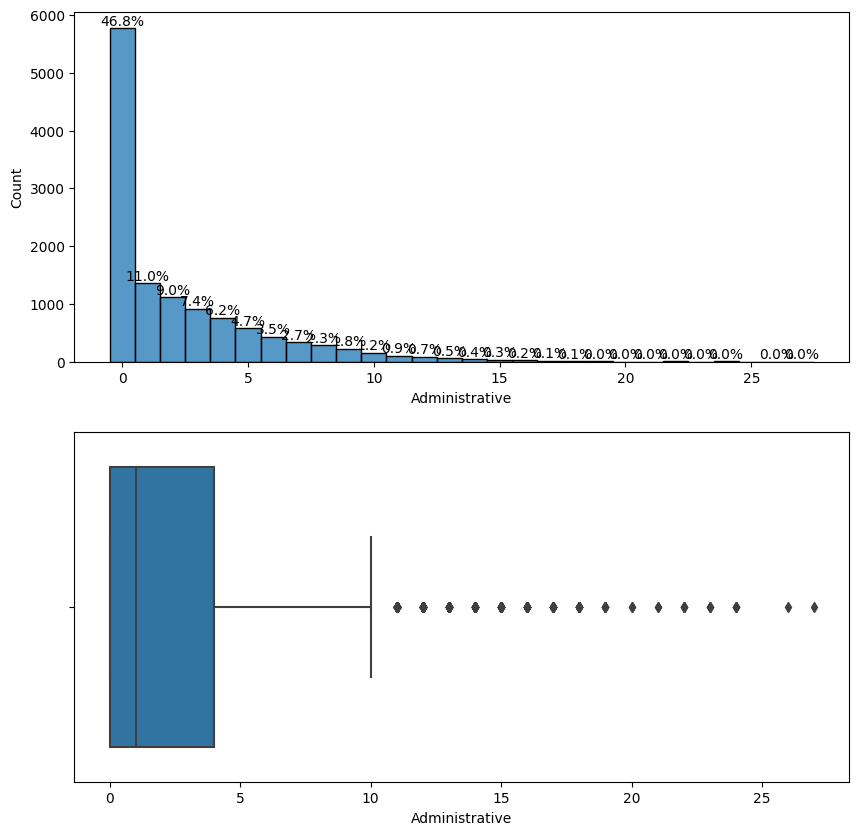

In [138]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="Administrative", discrete=True, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="Administrative", ax=ax2)

<Axes: xlabel='Administrative_Duration'>

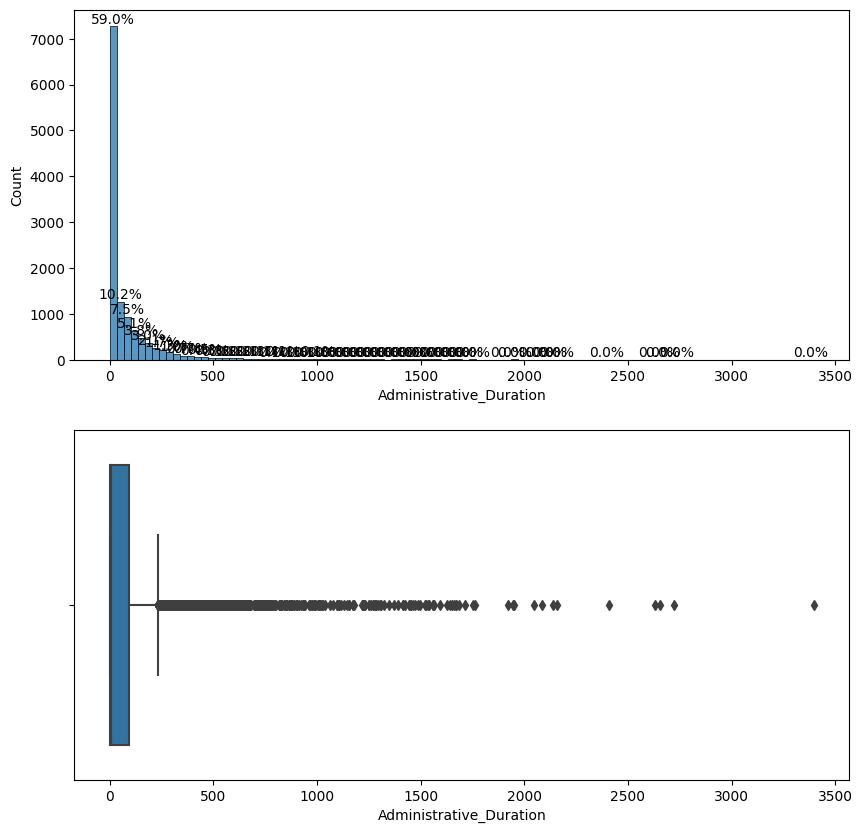

In [139]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="Administrative_Duration", bins=100, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="Administrative_Duration", ax=ax2)

<Axes: xlabel='Administrative', ylabel='Administrative_Duration'>

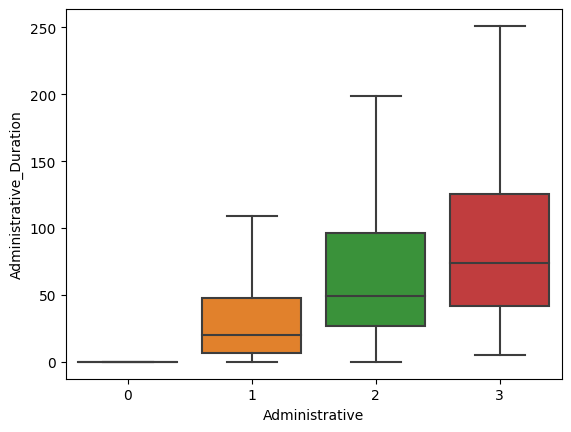

In [140]:
sns.boxplot(data=dataframe[dataframe["Administrative"] <= 3], y="Administrative_Duration", x="Administrative", showfliers=False)

<Axes: xlabel='Administrative', ylabel='Administrative_Duration'>

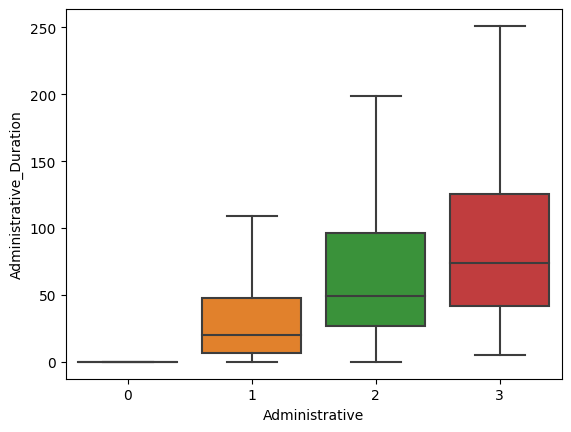

In [141]:
sns.boxplot(data=dataframe[dataframe["Administrative"] <= 3], y="Administrative_Duration", x="Administrative", showfliers=False)

По двум данным признакам заметно, что большинство пользователей не посещают административные страницы. Вероятнее всего в случае одного посещения данное действие было случайным, так как по последнему графику заметно, что медниана времени находится в районе 25 секунд. 

<Axes: xlabel='Informational'>

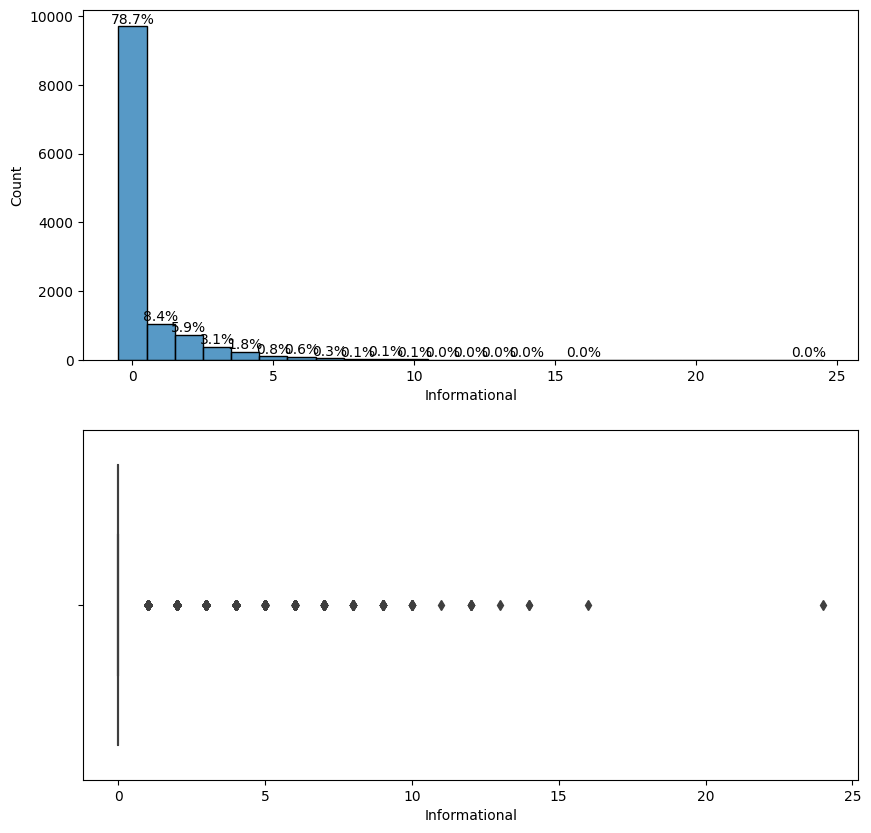

In [142]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="Informational", discrete=True, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="Informational", ax=ax2)

<Axes: xlabel='Informational_Duration'>

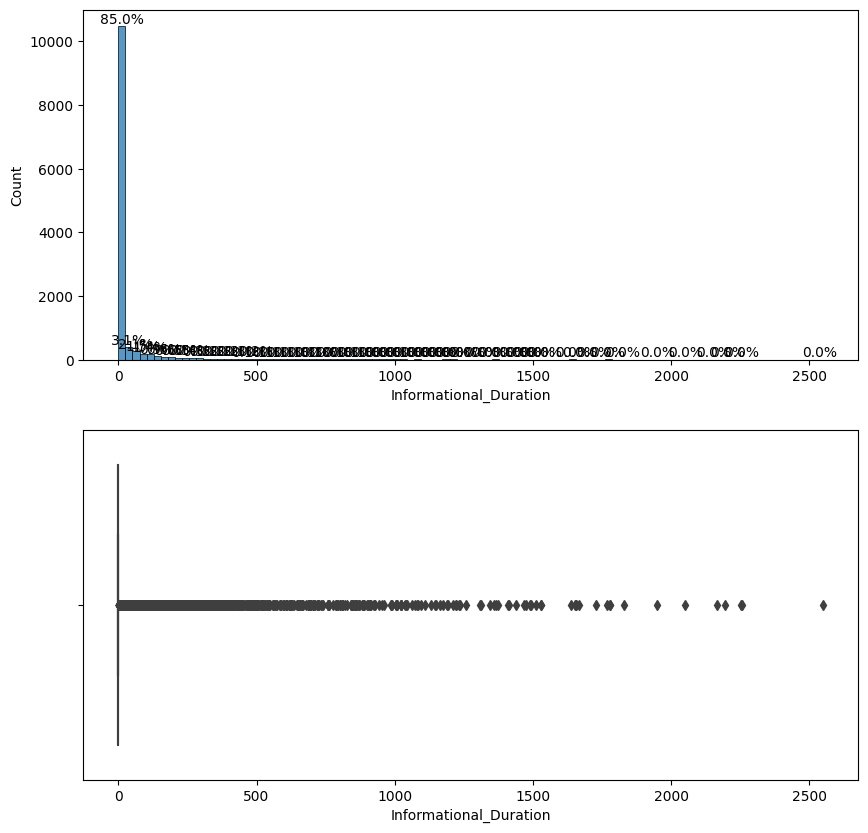

In [143]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="Informational_Duration", bins=100, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="Informational_Duration", ax=ax2)

<Axes: xlabel='Informational', ylabel='Informational_Duration'>

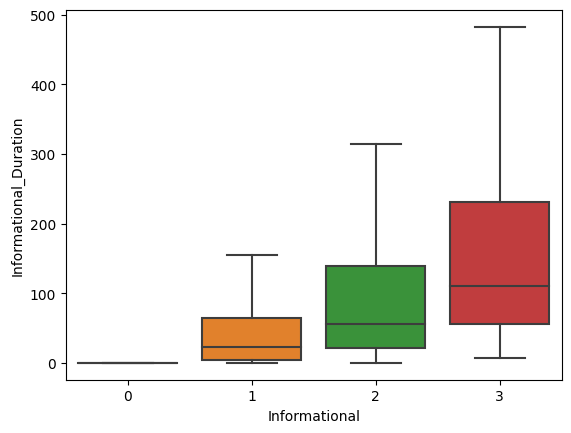

In [144]:
sns.boxplot(data=dataframe[dataframe["Informational"] <= 3], y="Informational_Duration", x="Informational", showfliers=False)

В случае информационных страниц ситуация более четкая, более 85% ни разу не посетили данную страницу. Однако с ростом числа посещений время проведенное на данных страницах растет значительнее в сравнении с административными, и рассматривать их как случайные посещения нет смысла

<Axes: xlabel='ProductRelated'>

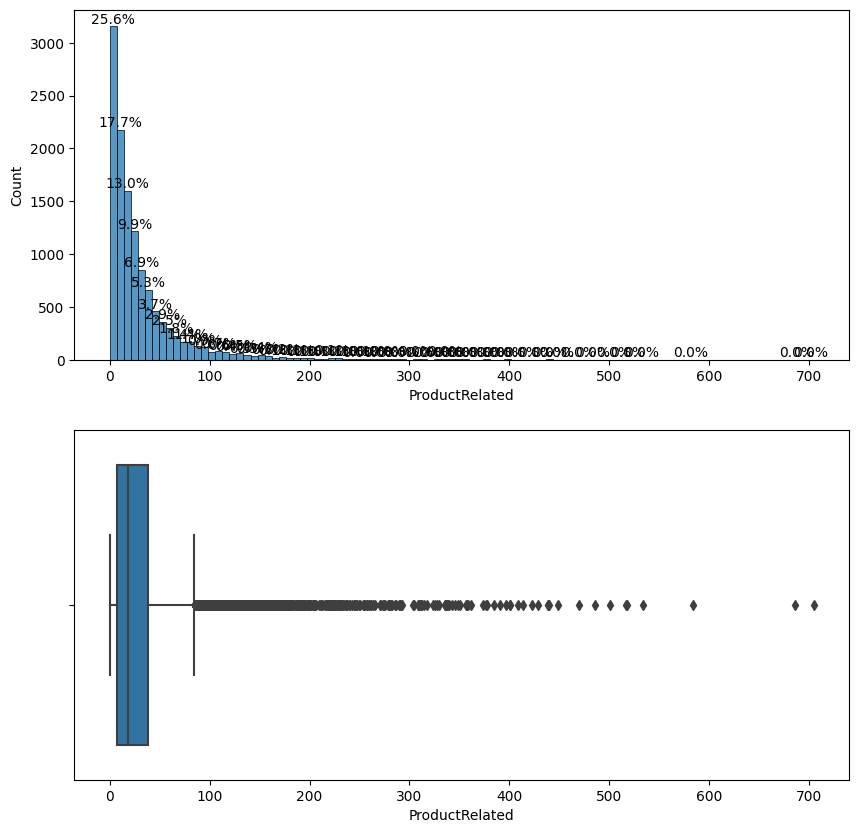

In [145]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="ProductRelated", bins=100, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="ProductRelated", ax=ax2)

<Axes: xlabel='ProductRelated_Duration'>

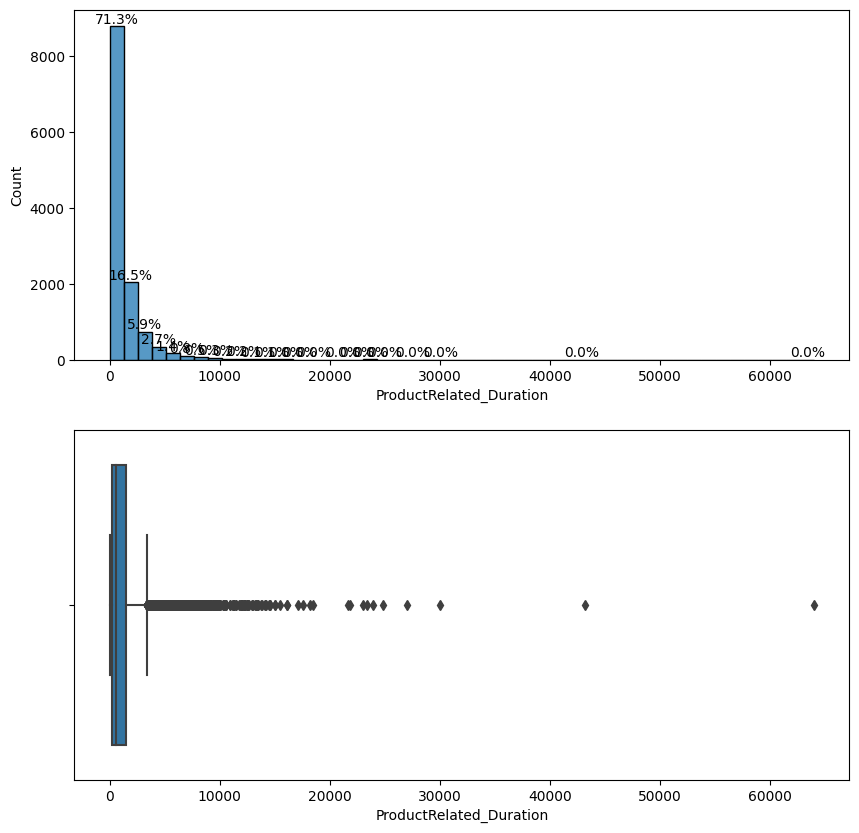

In [146]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

hist = sns.histplot(data=dataframe, x="ProductRelated_Duration", bins=50, ax=ax1)
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)

sns.boxplot(data=dataframe, x="ProductRelated_Duration", ax=ax2)

В отличии от предыдущих параметров, ProductRelated показывает наиболее высокие показатели, как и с точки зрения количесва посещений, так и с точки зрения времени, проведенного на данных сайтах

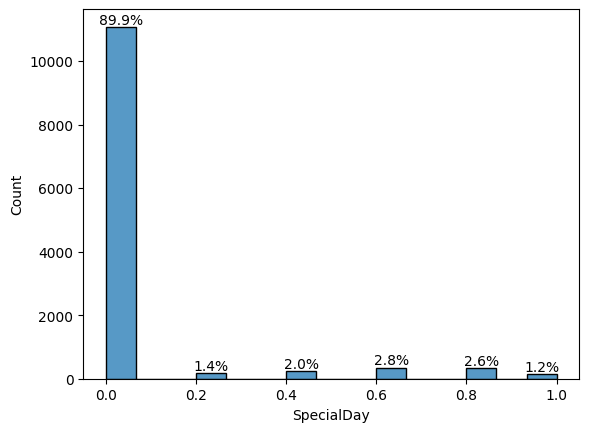

In [147]:
hist = sns.histplot(data=dataframe, x="SpecialDay")
# Calculating the precentage of feature
labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
hist.bar_label(hist.containers[1], labels=labels)
plt.show()

Только около 10% покупок связаны с праздниками

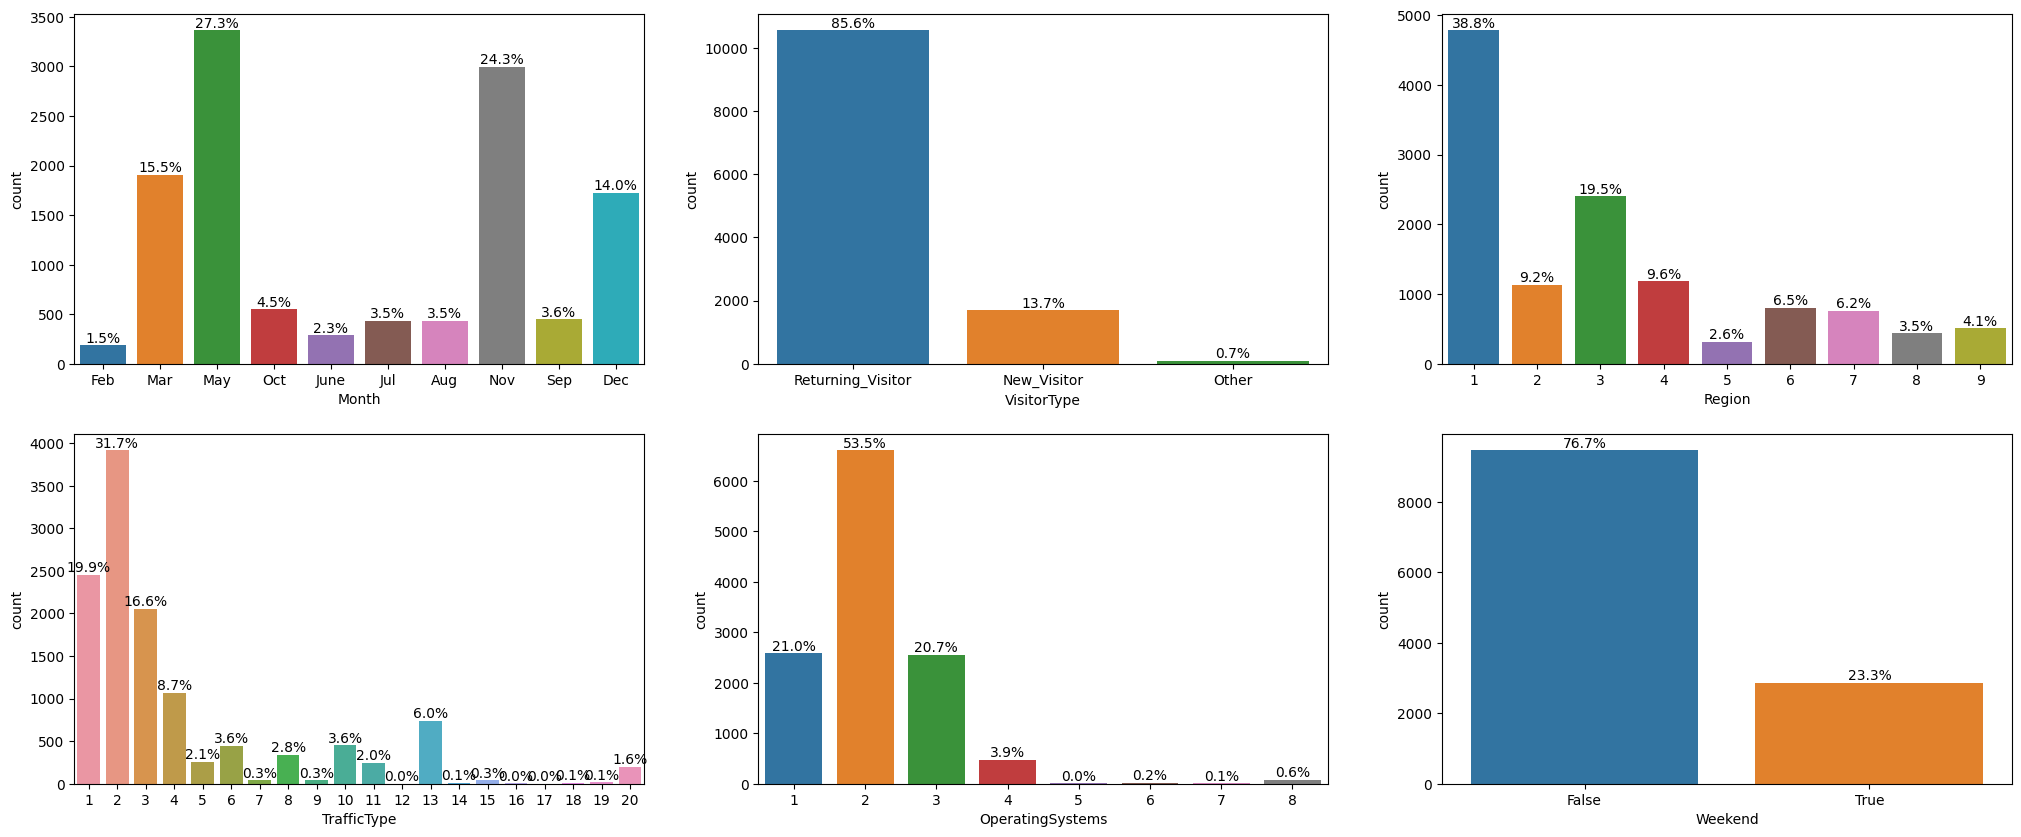

In [148]:
left_features = ['Month', 'OperatingSystems', 'Region', 'TrafficType', 'VisitorType', 'Weekend']

fig, axs = plt.subplots(2, 3, figsize=(25, 10))

for i, feature in enumerate(left_features):
    hist = sns.countplot(data=dataframe, x=feature, ax=axs[i%2][i%3])
    labels = [f'{v.get_height() / len(dataframe) * 100:.1f}%' if v.get_height() != 0 else '' for v in hist.patches]
    hist.bar_label(hist.containers[0], labels=labels)


Далее представлены анализ графиков слева на право, сверху вниз:
- В 'Month' отсутствует пару месяцев (Январь, Апрель)
- Большинство посетителей уже бывали на сайте (далее посмотрю сколько из них совершили покупку). Низкий показатель новых покупателей говорит о возможном низком притоке клиентов, возможно стоит рассмотреть какой-то способ привлечения новый людей.
- В данном тестовом задании 'Region' является не очень информативным признаком, даже если он будет сильно влиять на качество модели дать интерпритацию данному признаку невозможно. Как и с предыдущим пунктом имеет смысл привлечь пользователей из других регионов.
- Подробной информации о признаке 'TrafficType' я не смог найти(
- Наиболее популярные операционные системы 2, 1, 3 в порядке убывания (вероятнее всего информация о браузере излишняя и только конкретизации рынка и деталей сферы могла бы дать понимание важности данного признака)
- Большинство покупок совершено в выходныее дни. Возможно стоит предлагать рекламу именно в эти дни. (Далее посмотрю сколько из них совершили покупку)

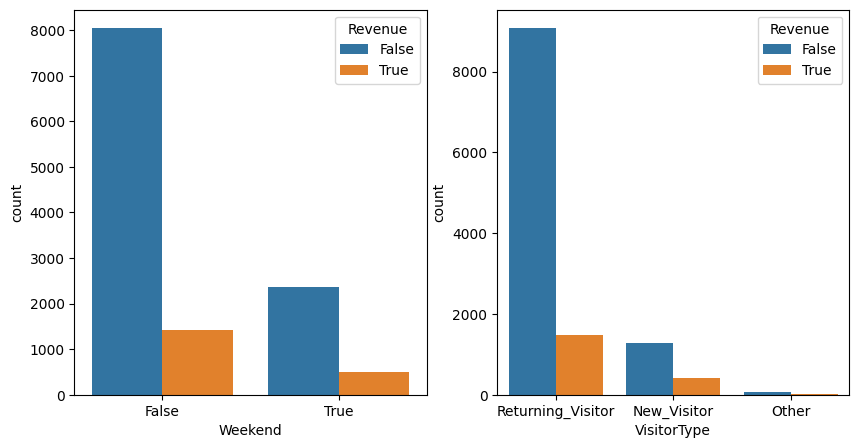

In [149]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=dataframe, x="Weekend", hue="Revenue", ax=ax1)
sns.countplot(data=dataframe, x="VisitorType", hue="Revenue", ax=ax2)
plt.show()

Из этих графиков видно, что покупательная способность, в процентном соотношении не зависит от дня недели.

Однако, второй график показывает, что покупательная способность возвращающихся покупателей в разы мешьше, чем новых.

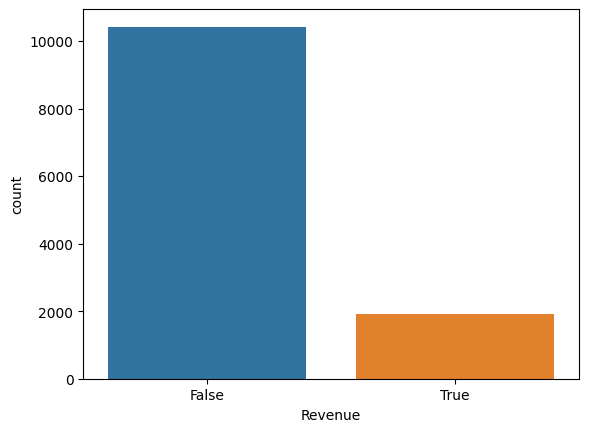

In [150]:
sns.countplot(data=dataframe, x="Revenue")
plt.show()

Также важно показать, что датасет значительно смещен в пользу класса 'Revenue'=False

### Correlation analysis and Feature selection

Перед данным этапом надо провести экодинк параметров

In [151]:

# Dropping Target feature to make it last after encoding another feature
revenue = dataframe['Revenue']
dataframe.drop(['Revenue'], axis=1, inplace=True)

# Encoding VisitorType and dropping it
dataframe = pd.concat([dataframe, pd.get_dummies(dataframe['VisitorType'], prefix="VisitorType"), revenue], axis=1).drop(['VisitorType'], axis=1)

# Converting Revenue and Weekend to Integer
dataframe['Revenue'] = dataframe['Revenue'].astype(int)
dataframe['Weekend'] = dataframe['Weekend'].astype(int)

# Convert Month to its equivalent month number
dataframe.loc[dataframe['Month'] == 'June', 'Month'] = 'Jun'
dataframe['Month'] = pd.to_datetime(dataframe['Month'], format='%b')
dataframe['Month'] = dataframe['Month'].dt.month

0        False
1        False
2        False
3        False
4        False
         ...  
12325    False
12326    False
12327    False
12328    False
12329    False
Name: Revenue, Length: 12330, dtype: bool


<Axes: title={'center': 'Pearson'}>

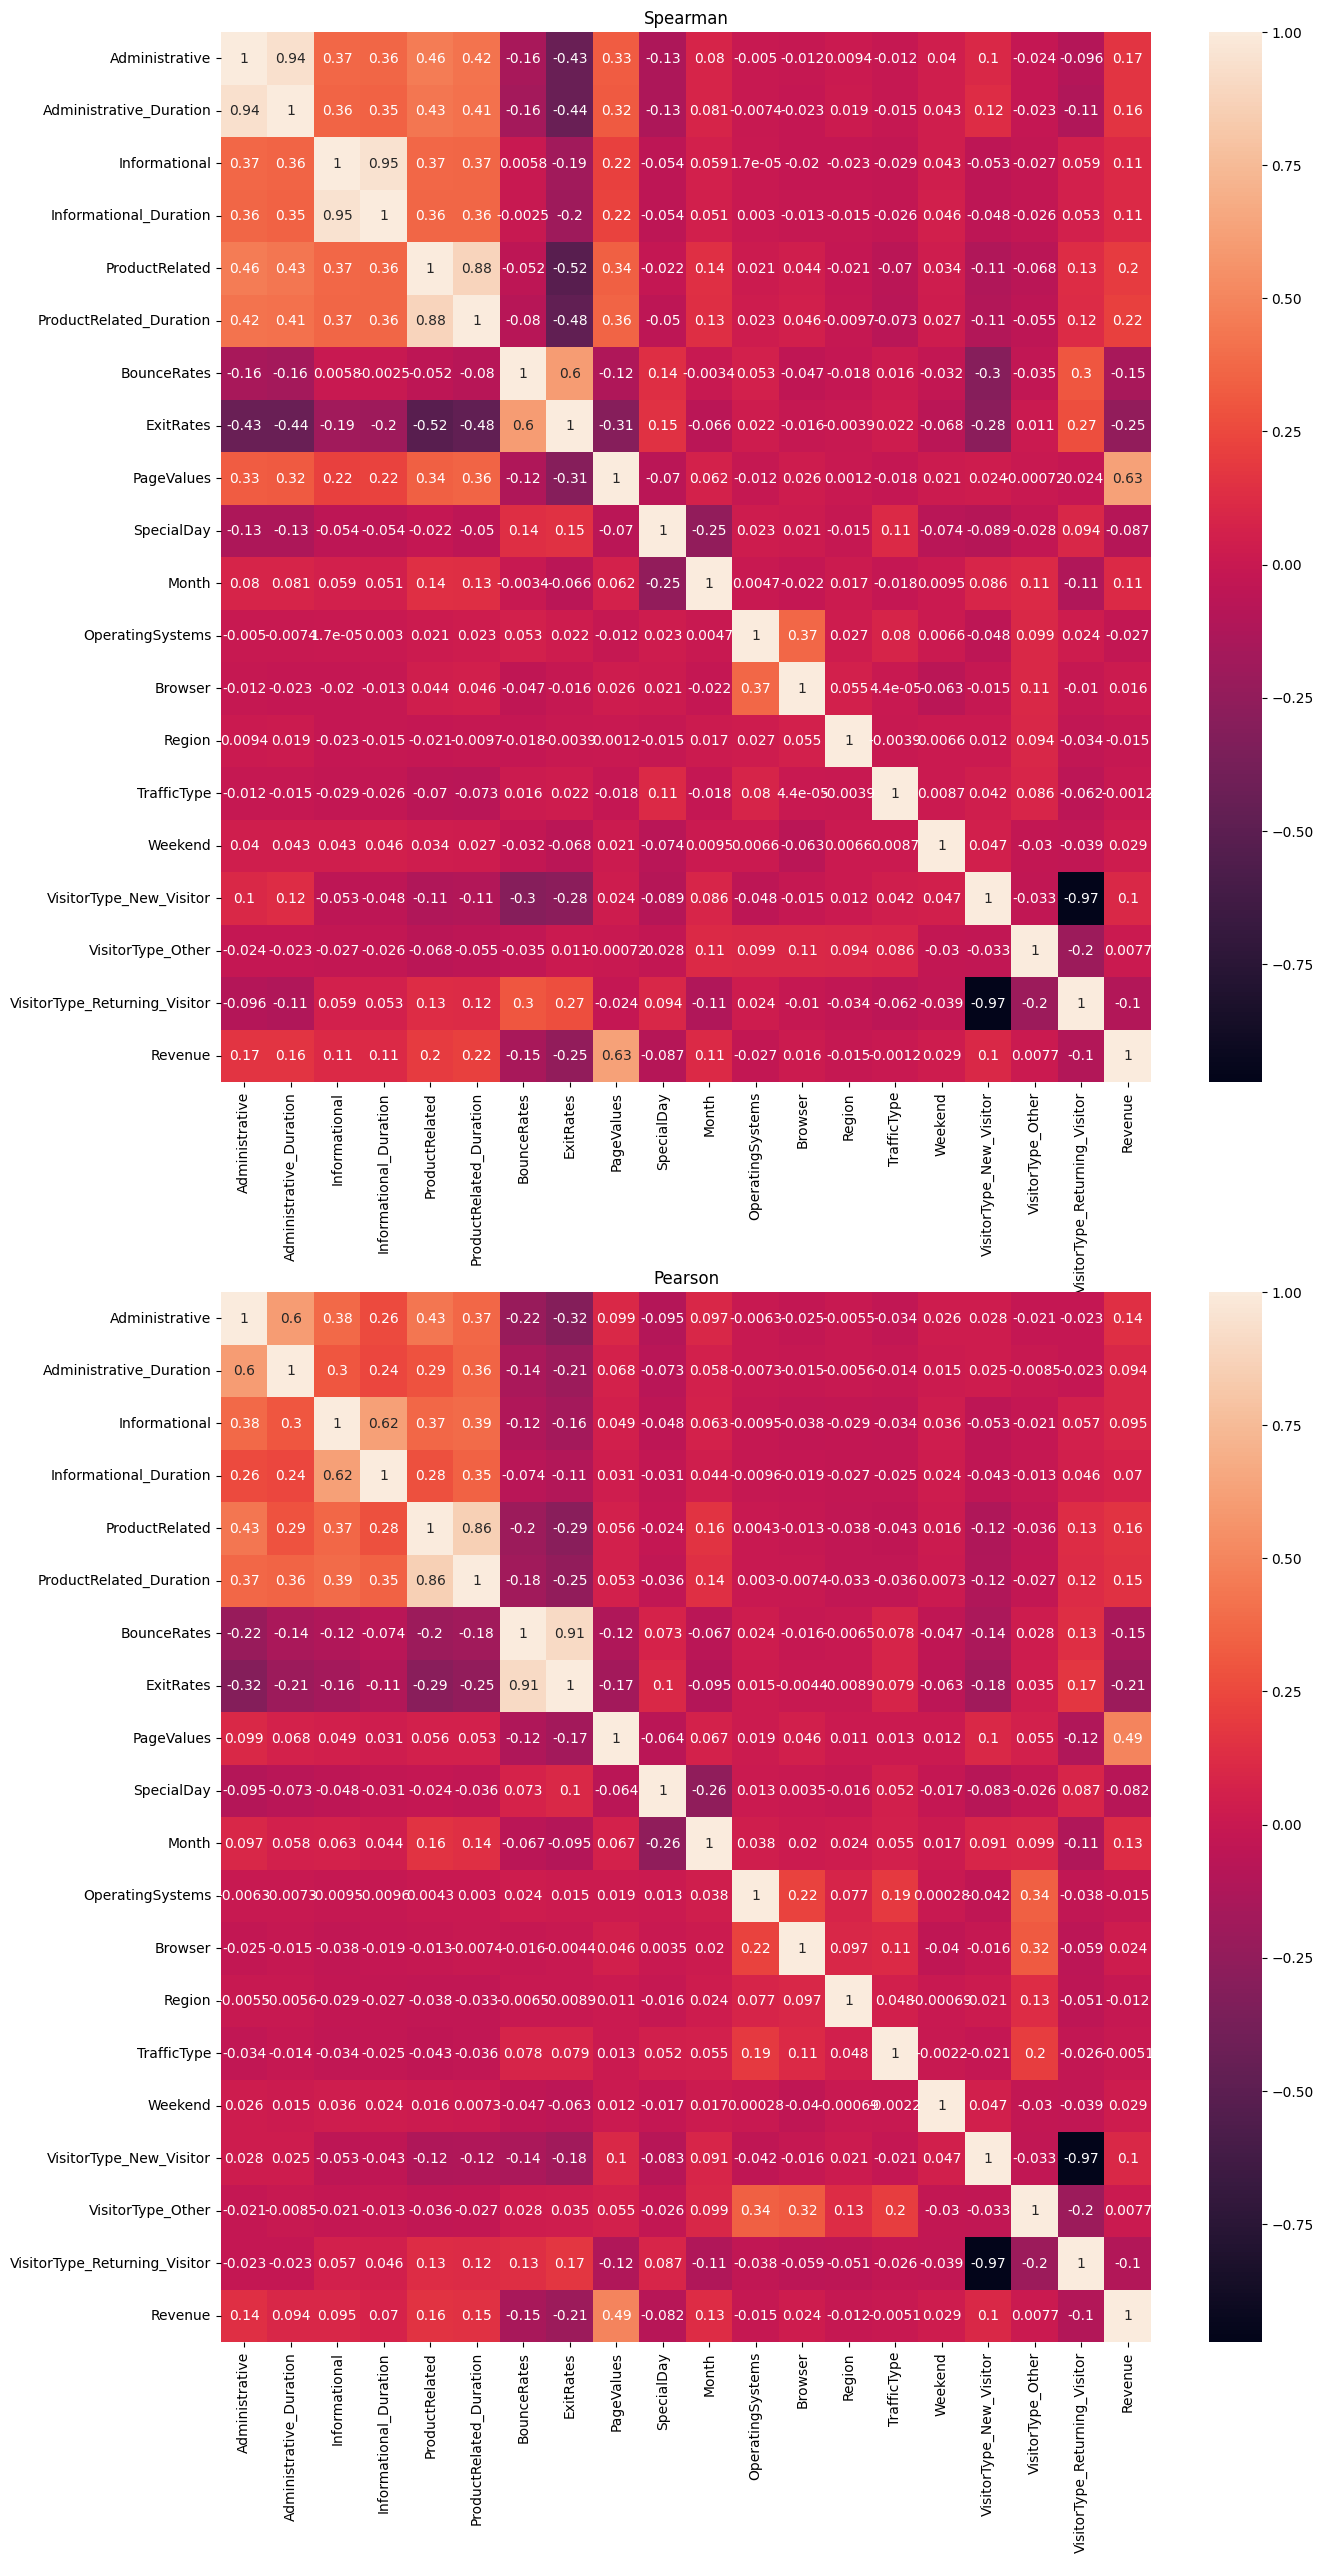

In [152]:
# Computing Spearman correlation matrix
spearman = dataframe.corr(method='spearman')

# Computing Pearson correlation matrix
pearson = dataframe.corr(method='pearson')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 30)) 
ax1.set(title='Spearman')
ax2.set(title='Pearson')

sns.heatmap(spearman, xticklabels=spearman.columns, yticklabels=spearman.columns, annot=True, ax=ax1)
sns.heatmap(pearson, xticklabels=pearson.columns, yticklabels=pearson.columns, annot=True, ax=ax2)

Из графиков в предыдущем пункте можно заметить, что распределения не сильно похожи на нормальное, а также взаимосвязь между разными параметрами можно назвать линейной только в редких случаях, поэтому воспользуесмя тестом ранговой корреляции Спирмена

Удалим параметры которые слабо коррелируют с таргетом, а именно все параметры, корреляция которых меньше 0.05 по модулю.
Т.е. 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Weekend', 'VisitorType_Other'. Возможно можно было бы их преобразовать, однако в силу отсутствия подробностей домена данных, я их просто уберу.

Также можно избавиться от 'ProductRelated', 'Administrative_Duration', 'Informational_Duration', 'BounceRates', так как они высоко коррелируют между соответсвующими признаками (для 'BounceRates' это 'ExitRates') и не превносят новой информации

In [157]:
drop_features = ['OperatingSystems', 
                 'Browser', 
                 'Region', 
                 'TrafficType', 
                 'Weekend', 
                 'VisitorType_Other', 
                 'ProductRelated', 
                 'Administrative_Duration', 
                 'Informational_Duration', 
                 'BounceRates',
                 ]

dataframe.drop(drop_features, axis=1, inplace=True)

In [158]:
dataframe.sample(5)

,Administrative,Informational,ProductRelated_Duration,ExitRates,PageValues,SpecialDay,Month,VisitorType_New_Visitor,VisitorType_Returning_Visitor,Revenue
8532,1,0,593.000000,0.013542,0.000000,0.0,11,False,True,0
10508,0,0,0.000000,0.200000,0.000000,0.0,11,False,True,0
10863,5,0,6225.988835,0.025012,7.963976,0.0,11,False,True,1
9978,6,1,1858.833333,0.011818,50.176936,0.0,12,False,True,0
2287,0,0,1652.000000,0.073333,0.000000,0.0,5,False,True,0


## Model fitting

Как уже до этого было замечено мощность двух целевых классов не совпадает, по этому будем разделять выборку с использованием стратификации, чтобы валидационная и обучающая выборки совпадали по частоте соответсвующих классов. Также отскейлим данные

In [209]:

X = dataframe.drop('Revenue', axis=1).to_numpy()
y = dataframe['Revenue'].to_numpy()
# Scaling
X = StandardScaler().fit_transform(X)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)



Для таких неоднородных и такого большого количества данных хорошо подходят модели основанные на деревьях, такие как RandomForest и различные градиентные бустинги. 

RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_split=20, n_estimators=200)
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3127
           1       0.74      0.58      0.65       572

    accuracy                           0.90      3699
   macro avg       0.84      0.77      0.80      3699
weighted avg       0.90      0.90      0.90      3699



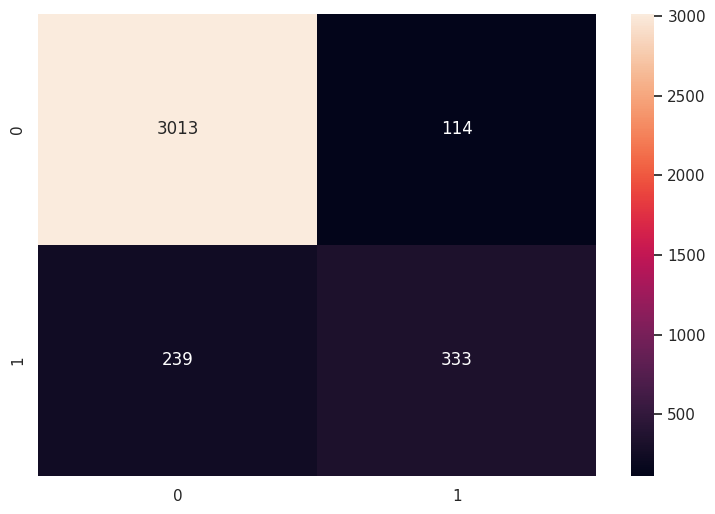

In [210]:
param_grid = {
    "n_estimators": [100, 200, 500],
    'max_features': ['sqrt', 'log2', None],
    "max_depth": [1, 5, 10, 15],
    "min_samples_split": [10, 20, 30],
    "criterion": ["gini", "entropy"],
}

randomForest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, n_jobs=-1)
randomForest.fit(X_train, y_train)

# Print params of best found model
print(randomForest.best_estimator_)

# Calculates the metrics
preds = randomForest.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
plt.show()

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3127
           1       0.72      0.56      0.63       572

    accuracy                           0.90      3699
   macro avg       0.82      0.76  

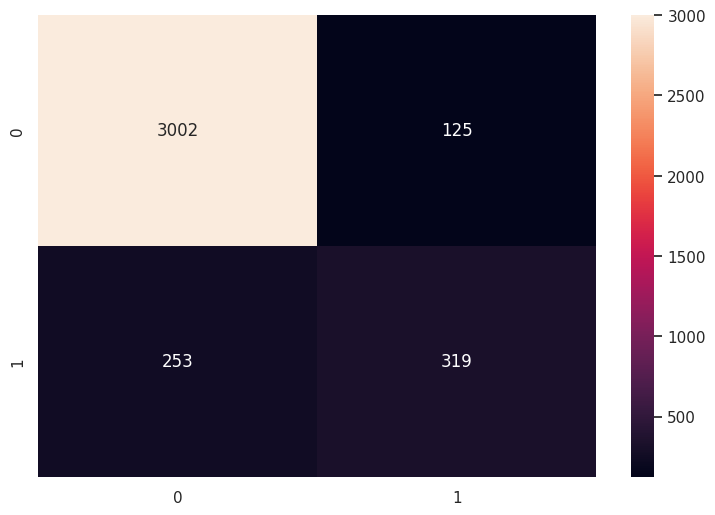

In [211]:
param_grid = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [10, 20, 30],
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "gamma": [0, 0.1, 0.5],
}

xgb = GridSearchCV(XGBClassifier(), param_grid=param_grid, n_jobs=-1)
xgb.fit(X_train, y_train)

# Print params of best found model
print(xgb.best_estimator_)

# Calculates the metrics
preds = xgb.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
plt.show()

LGBMClassifier(max_depth=10, min_child_samples=5, n_estimators=25,
               num_leaves=30)
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3127
           1       0.74      0.57      0.64       572

    accuracy                           0.90      3699
   macro avg       0.83      0.76      0.79      3699
weighted avg       0.90      0.90      0.90      3699



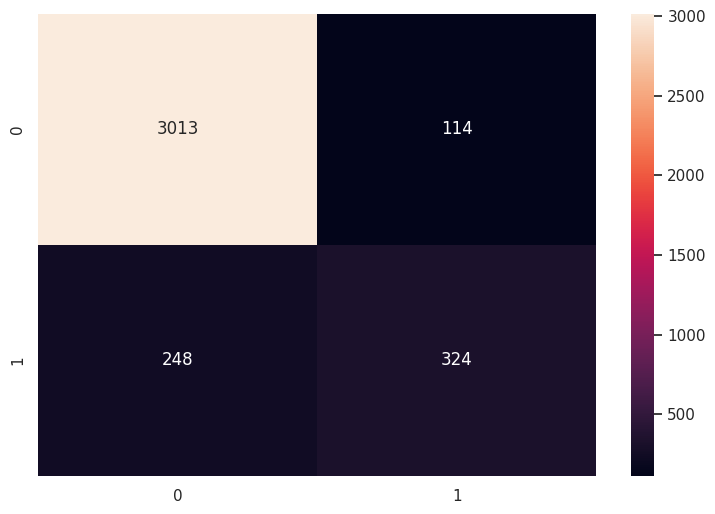

In [212]:
param_grid = {
    "n_estimators": [1, 10, 25, 50, 100],
    "max_depth": [10, 20, 30],
    "learning_rate": [1e-1, 1e-2, 1e-3],
    "num_leaves": [20, 30, 40],
    "min_child_samples": [5, 10, 20],
}

lgbm = GridSearchCV(LGBMClassifier(), param_grid=param_grid, n_jobs=-1)
lgbm.fit(X_train, y_train)

# Print params of best found model
print(lgbm.best_estimator_)

# Calculates the metrics
preds = lgbm.best_estimator_.predict(X_test)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt="d")
plt.show()

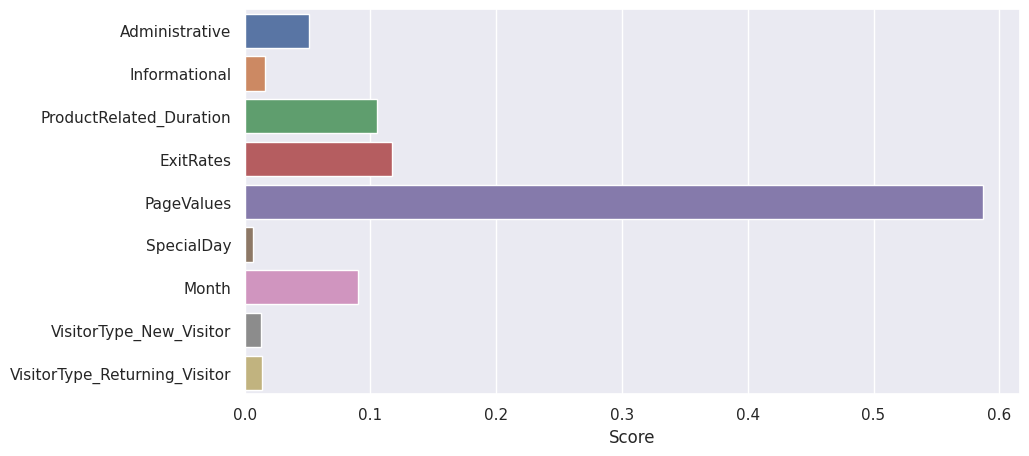

In [214]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plotting feature importance
importances = pd.DataFrame(randomForest.best_estimator_.feature_importances_, index=dataframe.drop('Revenue', axis=1).columns, columns=['Score'])
sns.barplot(data=importances, y=importances.index, x=importances['Score'], ax=ax)
plt.show()

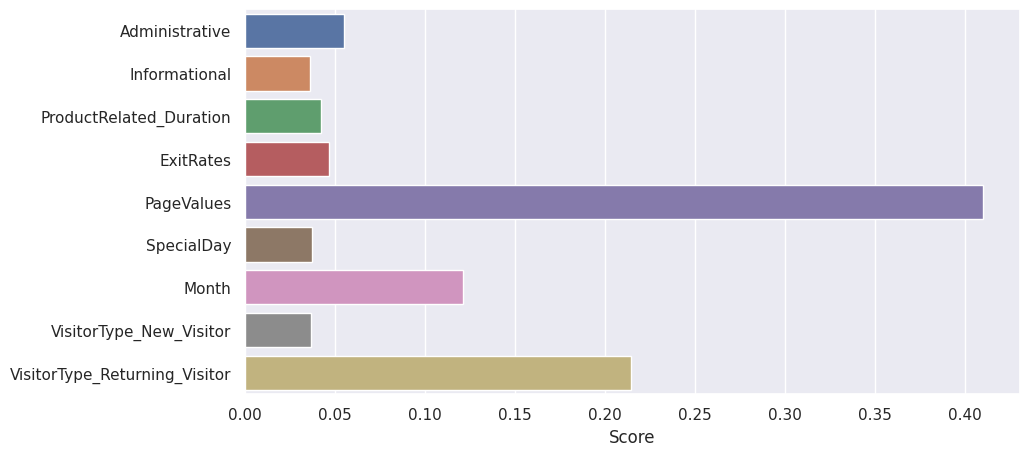

In [215]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plotting feature importance
importances = pd.DataFrame(xgb.best_estimator_.feature_importances_, index=dataframe.drop('Revenue', axis=1).columns, columns=['Score'])
sns.barplot(data=importances, y=importances.index, x=importances['Score'], ax=ax)
plt.show()

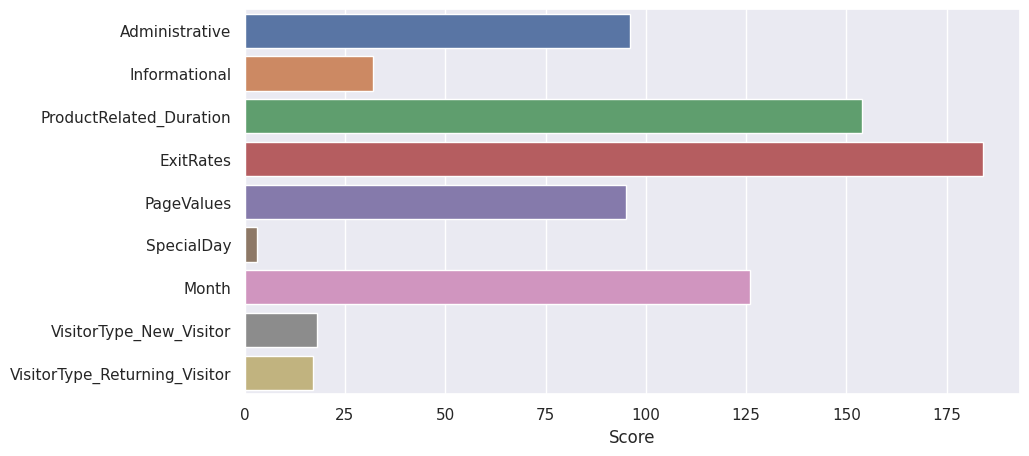

In [216]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plotting feature importance
importances = pd.DataFrame(lgbm.best_estimator_.feature_importances_, index=dataframe.drop('Revenue', axis=1).columns, columns=['Score'])
sns.barplot(data=importances, y=importances.index, x=importances['Score'], ax=ax)
plt.show()

## Conclusions

В результате получились достаточно хорошие результаты, все модели показали приблизительно одинаковый результат после файнтюна,однако у всех страдает точность предсказаний для второго класса (метка - 1). Дальнейшим развитием этой работы, может послужить Oversampling меньшего класса для балансировки классов.

Также стоит отметить отсутсвие доменной информации о датасете, присутствие которой моголо бы быть полезным на этапах EDA и feature selection